In [1]:
%load_ext autoreload
%autoreload 2

import random
import torch
import json
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [2]:
import os, sys
dir2 = os.path.abspath('')
dir1 = os.path.dirname(dir2)
if not dir1 in sys.path: sys.path.append(dir1)

from utils import set_seed
set_seed(0)

C:\Envs\pointer-network\lib\site-packages\torch\__init__.py:421: UserWarning: torch.set_deterministic is deprecated and will be removed in a future release. Please use torch.use_deterministic_algorithms instead
  warnings.warn((


# Load data, OCR and labels

In [24]:
s = sys.path


from preprocess_data import generate_documents

documents = generate_documents("address",
                               r"C:\Git\blog-post-content\pointer-network\sroie\ocr",
                               r"C:\Git\blog-post-content\pointer-network\sroie\labels",
                               r"C:\Git\blog-post-content\pointer-network\sroie\images")


The ground truth is a rectangle on the page that delimites where the ground is located. On the following example it is displayed in red, all the tokens transcribed by pytesseract are in blue.

In [26]:
from utils import display_doc
display_doc(documents[3]).show()

## Matching the ground truth to tokens

In [6]:
from utils import ground_truth_match
for doc in tqdm(documents.values()):
    doc['labels'] = ground_truth_match(doc['OCR'], doc['ground_truth'])

100%|██████████| 1000/1000 [00:02<00:00, 385.83it/s]


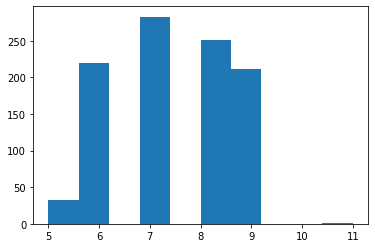

In [7]:
lengths = [
    len(doc['labels'])
    for doc in documents.values()
]

plt.figure()
plt.hist(lengths)
plt.show()

We notice some outliers at 11 words, therefore we remove addresses where the number of matched tokens is higher than the number of words in the ground truth.

In [8]:
failed_matching = []
for key, doc in documents.items():
    length_address = len(doc['address'].split())
    if length_address != len(doc['labels']):
        failed_matching.append(key)

In [9]:
for key in failed_matching:
    del documents[key]

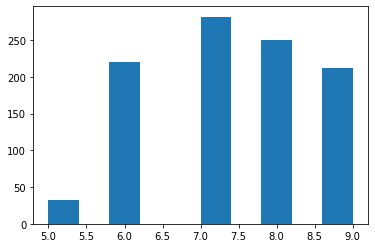

In [10]:
lengths = [
    len(doc['labels'])
    for doc in documents.values()
]

plt.figure()
plt.hist(lengths)
plt.show()

# Pre-process data

## Text pre-processing

In [11]:
from utils import text_pre_processing

We put everything in lowercase and only keep alphabet letters and numbers. 

In [12]:
data = [
    (
        key,
        [
            (text_pre_processing(token['text']), token['position']) for token in doc['OCR']
        ],
        doc['labels']
    )
    for key, doc in documents.items()
]


# Split train / validation / test

We will train the model on train, find a threshold on validation and make sure it works as expected on test

In [13]:
N_DOCS = len(data)
split = 60, 20, 20  # train / validation / test

random.shuffle(data)
n_train = int(split[0] / 100 * N_DOCS)
n_val = n_train + int(split[1] / 100 * N_DOCS)

dataset_split = {
    'train': [doc for doc in data[:n_train]],
    'validation': [doc for doc in data[n_train:n_val]],
    'test': [doc for doc in data[n_val:]],
}

In [14]:
dataset_split['train'][0][1][:5]

[('invoiced', [102, 104, 173, 119]),
 ('company', [180, 108, 260, 123]),
 ('8550', [101, 133, 143, 147]),
 ('tamara', [149, 133, 218, 147]),
 ('extensions', [226, 132, 320, 147])]

# Mapping the characters

We decided on a simple architecture with character level embedding that we feed to an encoder to get word level embedding. Here we map each character to a number.

In [15]:
characters = set()
for _, doc_input, _ in dataset_split['train']:
    for word, _ in doc_input:
        characters |= set([x for x in word])
characters = sorted(list(characters))
characters_mapping = {char: i + 1 for i, char in enumerate(characters)}  # + 1 to account for the stop token
len(characters_mapping)

36

In [16]:
dataset_split = {
    mode: [
        (
            key,
            (
                [
                    ([characters_mapping[c] for c in word], position)
                    for word, position in input_data
                ]
            ),
            target
        )
        for key, input_data, target in dataset_split[mode]
    ]
    for mode in dataset_split
}

## Tensorification

In [17]:
from utils import make_tensors

tensors_data = {}
for mode in dataset_split:
    tensors_data[mode] = make_tensors(dataset_split[mode])


In [18]:
for mode in tensors_data:
    print('-'*40)
    print('mode', mode)
    print('words', tensors_data[mode].words.shape)
    print('positions', tensors_data[mode].positions.shape)
    print('target', tensors_data[mode].target.shape)


----------------------------------------
mode train
words torch.Size([598, 93, 33])
positions torch.Size([598, 93, 4])
target torch.Size([598, 10])
----------------------------------------
mode validation
words torch.Size([199, 90, 35])
positions torch.Size([199, 90, 4])
target torch.Size([199, 10])
----------------------------------------
mode test
words torch.Size([200, 88, 33])
positions torch.Size([200, 88, 4])
target torch.Size([200, 10])


## Wrapping it up in a TensorDataset

In [19]:
from torch.utils.data import TensorDataset, DataLoader 
datasets = {
    mode: TensorDataset(
            tensors_data[mode].keys,
            tensors_data[mode].words.type(torch.LongTensor),
            tensors_data[mode].positions,
            tensors_data[mode].target.type(torch.LongTensor)
        )
    for mode in tensors_data
}

In [20]:
tensors_data[mode].target 

tensor([[15, 16, 17,  ...,  0,  0,  0],
        [53, 54, 55,  ..., 60, 61,  0],
        [10, 11, 12,  ...,  0,  0,  0],
        ...,
        [ 9, 10, 11,  ...,  0,  0,  0],
        [ 2,  3,  4,  ...,  9,  0,  0],
        [ 5,  6,  7,  ..., 12,  0,  0]])

# Training loop

In [21]:
from utils import loss_function
from model import Model

The following hyper parameters are guesses and they have been slightly hand-tuned. For best results we could do a grid search or Bayesian optimization to find optimal hyper parameters.

In [22]:
batch_size = 16
embedding_dim = 64
position_dim = 10
learning_rate = 5e-3
n_epochs = 80

In [23]:
from utils import get_loaders

train_loader, val_loader, test_loader = get_loaders(datasets, batch_size)

In [24]:
max_seq_len = 10

model = Model(
    len(characters_mapping) + 1, # + 1 to account for the stop token with index 0
    embedding_dim,
    position_dim,
    max_seq_len
)


optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



In the metrics that we compute, the accuracy tells us how often we are able to make a perfect prediction. The Precision-Recall AUC tells us how well we are able to distinguish between correct and incorrect predictions which will be key when we want to threshold. A low PR-AUC means that you have to pick between recall and precision, a high PR-AUC means you should be able to find a better trade-off between the two.

In [25]:
from utils import train_model
train_losses, val_losses, val_metrics = train_model(n_epochs, model, optimizer, train_loader, val_loader)

100%|██████████| 38/38 [00:11<00:00,  3.83it/s]
/Users/jocelyn/Documents/forms/ml_framework/venv/lib/python3.7/site-packages/sklearn/metrics/ranking.py:528: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]
  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 0, train_loss=4.020679925617419, val_loss=3.863607479975774 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 1, train_loss=3.7862254130212882, val_loss=3.413567231251643 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 2, train_loss=3.4110304493653145, val_loss=3.2076846086061916 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 3, train_loss=3.174034099829824, val_loss=2.901814680833083 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 4, train_loss=2.911397419477764, val_loss=2.696589763347919 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 5, train_loss=2.716479652806332, val_loss=2.4251108903151293 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 6, train_loss=2.486576425401788, val_loss=2.2766320888812723 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 7, train_loss=2.3403186107936658, val_loss=2.2319948214751024 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 8, train_loss=2.1605849046456185, val_loss=2.1570631724137526 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 9, train_loss=1.9206362147080271, val_loss=1.8590282385165875 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 10, train_loss=1.6737481418408846, val_loss=1.6425869831672082 
 val_metrics={'accuracy': 0.05025125628140704, 'PR-AUC': 0.08643093215786654}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 11, train_loss=1.5108925104141235, val_loss=1.3467541199464064 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 12, train_loss=1.4515507346705387, val_loss=1.880582571029663 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 13, train_loss=1.5173128749194897, val_loss=1.3065524192956777 
 val_metrics={'accuracy': 0.010050251256281407, 'PR-AUC': 0.011826137640685016}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 14, train_loss=1.3149274869969017, val_loss=0.9521360397338867 
 val_metrics={'accuracy': 0.020100502512562814, 'PR-AUC': 0.02433197672472046}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 15, train_loss=1.1429197725496794, val_loss=0.8010535469421973 
 val_metrics={'accuracy': 0.16080402010050251, 'PR-AUC': 0.2436274724374063}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 16, train_loss=1.0698659357271696, val_loss=0.7337298209850605 
 val_metrics={'accuracy': 0.0, 'PR-AUC': nan}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 17, train_loss=1.0338875416078066, val_loss=0.623090230501615 
 val_metrics={'accuracy': 0.40703517587939697, 'PR-AUC': 0.5579110682842312}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 18, train_loss=1.011571024593554, val_loss=0.8820221836750324 
 val_metrics={'accuracy': 0.25125628140703515, 'PR-AUC': 0.628397805236868}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 19, train_loss=0.9789117166870519, val_loss=0.7475616106620202 
 val_metrics={'accuracy': 0.3869346733668342, 'PR-AUC': 0.685697985086255}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 20, train_loss=0.9761053166891399, val_loss=0.6716596071536725 
 val_metrics={'accuracy': 0.5829145728643216, 'PR-AUC': 0.8507197615844343}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 21, train_loss=0.9239878168231562, val_loss=0.6764198587490962 
 val_metrics={'accuracy': 0.5728643216080402, 'PR-AUC': 0.9003000639504671}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 22, train_loss=0.8150581356726194, val_loss=0.5004224364574139 
 val_metrics={'accuracy': 0.7939698492462312, 'PR-AUC': 0.9748906357795093}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 23, train_loss=0.7673571101929012, val_loss=0.34664662182331085 
 val_metrics={'accuracy': 0.8994974874371859, 'PR-AUC': 0.9870346424183067}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 24, train_loss=0.686401198569097, val_loss=0.37658533683189976 
 val_metrics={'accuracy': 0.6381909547738693, 'PR-AUC': 0.9666432687638823}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 25, train_loss=0.6570141707596026, val_loss=0.38022073874106777 
 val_metrics={'accuracy': 0.8391959798994975, 'PR-AUC': 0.984264599730214}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 26, train_loss=0.687515925419958, val_loss=0.40830378463635075 
 val_metrics={'accuracy': 0.6733668341708543, 'PR-AUC': 0.9676638770336601}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 27, train_loss=0.5755969215380518, val_loss=0.27817363234666675 
 val_metrics={'accuracy': 0.9396984924623115, 'PR-AUC': 0.995242109049673}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 28, train_loss=0.5453686588688901, val_loss=0.25109205738856244 
 val_metrics={'accuracy': 0.9346733668341709, 'PR-AUC': 0.996046027220834}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 29, train_loss=0.543946172845991, val_loss=0.2902215759341533 
 val_metrics={'accuracy': 0.9095477386934674, 'PR-AUC': 0.9956473597385086}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 30, train_loss=0.4717375675314351, val_loss=0.25650169585759824 
 val_metrics={'accuracy': 0.9396984924623115, 'PR-AUC': 0.9962035511751348}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 31, train_loss=0.4823720564967708, val_loss=0.2467375540962586 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9952283888545439}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 32, train_loss=0.4609006537418616, val_loss=0.2092741126051316 
 val_metrics={'accuracy': 0.9346733668341709, 'PR-AUC': 0.9942807307275099}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 33, train_loss=0.44750759868245377, val_loss=0.19801794135799775 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 0.9913449713525894}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 34, train_loss=0.4177935901833208, val_loss=0.16558166707937533 
 val_metrics={'accuracy': 0.9597989949748744, 'PR-AUC': 0.9942353221659606}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 35, train_loss=0.4524924974692495, val_loss=0.17053857245124304 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.9959023450024518}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 36, train_loss=0.5990002951339671, val_loss=0.358616190461012 
 val_metrics={'accuracy': 0.8391959798994975, 'PR-AUC': 0.9873022310161459}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 37, train_loss=0.5642474478012637, val_loss=0.2187313365821655 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 0.9948300764336646}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 38, train_loss=0.3984037967104661, val_loss=0.17860563815786287 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.9996382878452679}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 39, train_loss=0.3834183974877784, val_loss=0.2024607237141866 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9935647752355224}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 40, train_loss=0.49083013812962334, val_loss=0.23910924849601892 
 val_metrics={'accuracy': 0.9095477386934674, 'PR-AUC': 0.9973976819954886}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 41, train_loss=0.5312504140954268, val_loss=0.18458280368493155 
 val_metrics={'accuracy': 0.9396984924623115, 'PR-AUC': 0.9987312237505428}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 42, train_loss=0.3363194630334252, val_loss=0.2140910909152948 
 val_metrics={'accuracy': 0.9296482412060302, 'PR-AUC': 0.9994805436919276}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 43, train_loss=0.3331825705735307, val_loss=0.19136357049529368 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 0.9992551804847822}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 44, train_loss=0.34418766337789986, val_loss=0.19390891664303267 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9979308755921201}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 45, train_loss=0.2982404241828542, val_loss=0.19168514113586682 
 val_metrics={'accuracy': 0.9396984924623115, 'PR-AUC': 0.9996865437665963}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 46, train_loss=0.2657590792759469, val_loss=0.1785659808665514 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 0.9994769312489291}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 47, train_loss=0.2924427209716094, val_loss=0.14242027456370684 
 val_metrics={'accuracy': 0.9396984924623115, 'PR-AUC': 0.9996334868004465}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 48, train_loss=0.3155636717810443, val_loss=0.16306391458671826 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9996161278731169}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 49, train_loss=0.2271831107178801, val_loss=0.14616547847309938 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 1.0}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 50, train_loss=0.2746210745290706, val_loss=0.21094600211542386 
 val_metrics={'accuracy': 0.9346733668341709, 'PR-AUC': 0.9996351265441772}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 51, train_loss=0.2826006457601723, val_loss=0.19463542820169374 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9998367802491515}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 52, train_loss=0.33303512672060415, val_loss=0.18096442950459626 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.9999172578051556}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 53, train_loss=0.2799496010534073, val_loss=0.20032446344311422 
 val_metrics={'accuracy': 0.9296482412060302, 'PR-AUC': 0.9957667224611555}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 54, train_loss=0.3488414375797698, val_loss=0.20689648762345314 
 val_metrics={'accuracy': 0.914572864321608, 'PR-AUC': 0.9985155524374619}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 55, train_loss=0.3766334503889084, val_loss=0.12116762064397335 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9996599215682462}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 56, train_loss=0.305621082943521, val_loss=0.12915933046203393 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 0.9984589322187879}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 57, train_loss=0.25740904978623513, val_loss=0.15616775633623967 
 val_metrics={'accuracy': 0.9396984924623115, 'PR-AUC': 0.9979146458739845}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 58, train_loss=0.21644164827701293, val_loss=0.12498880779513946 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9997234000738121}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 59, train_loss=0.1857109476665133, val_loss=0.1050442627702768 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.9998094427855387}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 60, train_loss=0.21542727447261936, val_loss=0.11153238639235497 
 val_metrics={'accuracy': 0.9597989949748744, 'PR-AUC': 0.9998913436676293}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 61, train_loss=0.23806132405604186, val_loss=0.15071693091438368 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.9927766997878145}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 62, train_loss=0.48312876422546414, val_loss=0.34406582896526045 
 val_metrics={'accuracy': 0.864321608040201, 'PR-AUC': 0.9947673030157003}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 63, train_loss=0.3654033310319248, val_loss=0.21909067034721375 
 val_metrics={'accuracy': 0.9246231155778895, 'PR-AUC': 0.9989894620217191}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 64, train_loss=0.2236533586524035, val_loss=0.0890234038233757 
 val_metrics={'accuracy': 0.964824120603015, 'PR-AUC': 0.9997314783600272}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 65, train_loss=0.2522982077575044, val_loss=0.146725294395135 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.998153103206812}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 66, train_loss=0.24118816617288089, val_loss=0.15751469017078096 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9970999632224251}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 67, train_loss=0.21916569887023224, val_loss=0.16400826134933874 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.9995168979419993}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 68, train_loss=0.22256387613321604, val_loss=0.22133855894207954 
 val_metrics={'accuracy': 0.8944723618090452, 'PR-AUC': 0.9941528156644688}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 69, train_loss=0.21014848969092495, val_loss=0.1514923355470483 
 val_metrics={'accuracy': 0.9447236180904522, 'PR-AUC': 0.999197127013229}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 70, train_loss=0.16568849480857975, val_loss=0.15100225021776098 
 val_metrics={'accuracy': 0.9597989949748744, 'PR-AUC': 0.9998337756727292}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 71, train_loss=0.15477165962128261, val_loss=0.11357853540147726 
 val_metrics={'accuracy': 0.964824120603015, 'PR-AUC': 0.9998100115996359}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 72, train_loss=0.17240932657334365, val_loss=0.1387439495525681 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.999676002568923}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 73, train_loss=0.18780522357280316, val_loss=0.12367969783596121 
 val_metrics={'accuracy': 0.9597989949748744, 'PR-AUC': 0.9999456037671016}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 74, train_loss=0.17733779392744364, val_loss=0.14428989503246087 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9994023693290262}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 75, train_loss=0.2342779228561803, val_loss=0.14405836200771424 
 val_metrics={'accuracy': 0.9547738693467337, 'PR-AUC': 0.999889336346663}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 76, train_loss=0.22882548200064584, val_loss=0.12366247606965211 
 val_metrics={'accuracy': 0.964824120603015, 'PR-AUC': 0.9999189689893786}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 77, train_loss=0.13964560458828745, val_loss=0.11801876575471117 
 val_metrics={'accuracy': 0.9597989949748744, 'PR-AUC': 0.9999999999999996}


  0%|          | 0/38 [00:00<?, ?it/s]

Epoch 78, train_loss=0.14923559501767159, val_loss=0.1591277406192743 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 0.9999720789333714}


100%|██████████| 38/38 [00:11<00:00,  3.74it/s]


Epoch 79, train_loss=0.1537209685009561, val_loss=0.14865137830090064 
 val_metrics={'accuracy': 0.949748743718593, 'PR-AUC': 1.0000000000000002}


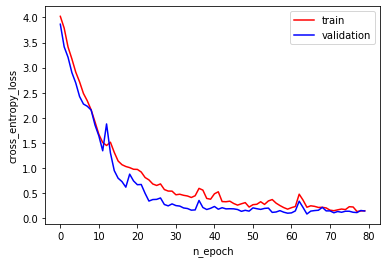

In [26]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, color='red', label="train")
plt.plot(val_losses, color='blue', label="validation")
plt.xlabel('n_epoch')
plt.ylabel('cross_entropy_loss')
plt.legend()
plt.show()

# Best validation accuracy

In [27]:
best_step = np.argmin(val_losses[:80])
model = torch.load(f'models/model_{best_step}.torch')
best_step, min(val_losses), val_metrics[best_step]

(64,
 0.0890234038233757,
 {'accuracy': 0.964824120603015, 'PR-AUC': 0.9997314783600272})

# Display prediction

In [28]:
for keys, words, positions, target in val_loader:
    overall_probabilities, peak_indices = model.forward(words, positions)
    break

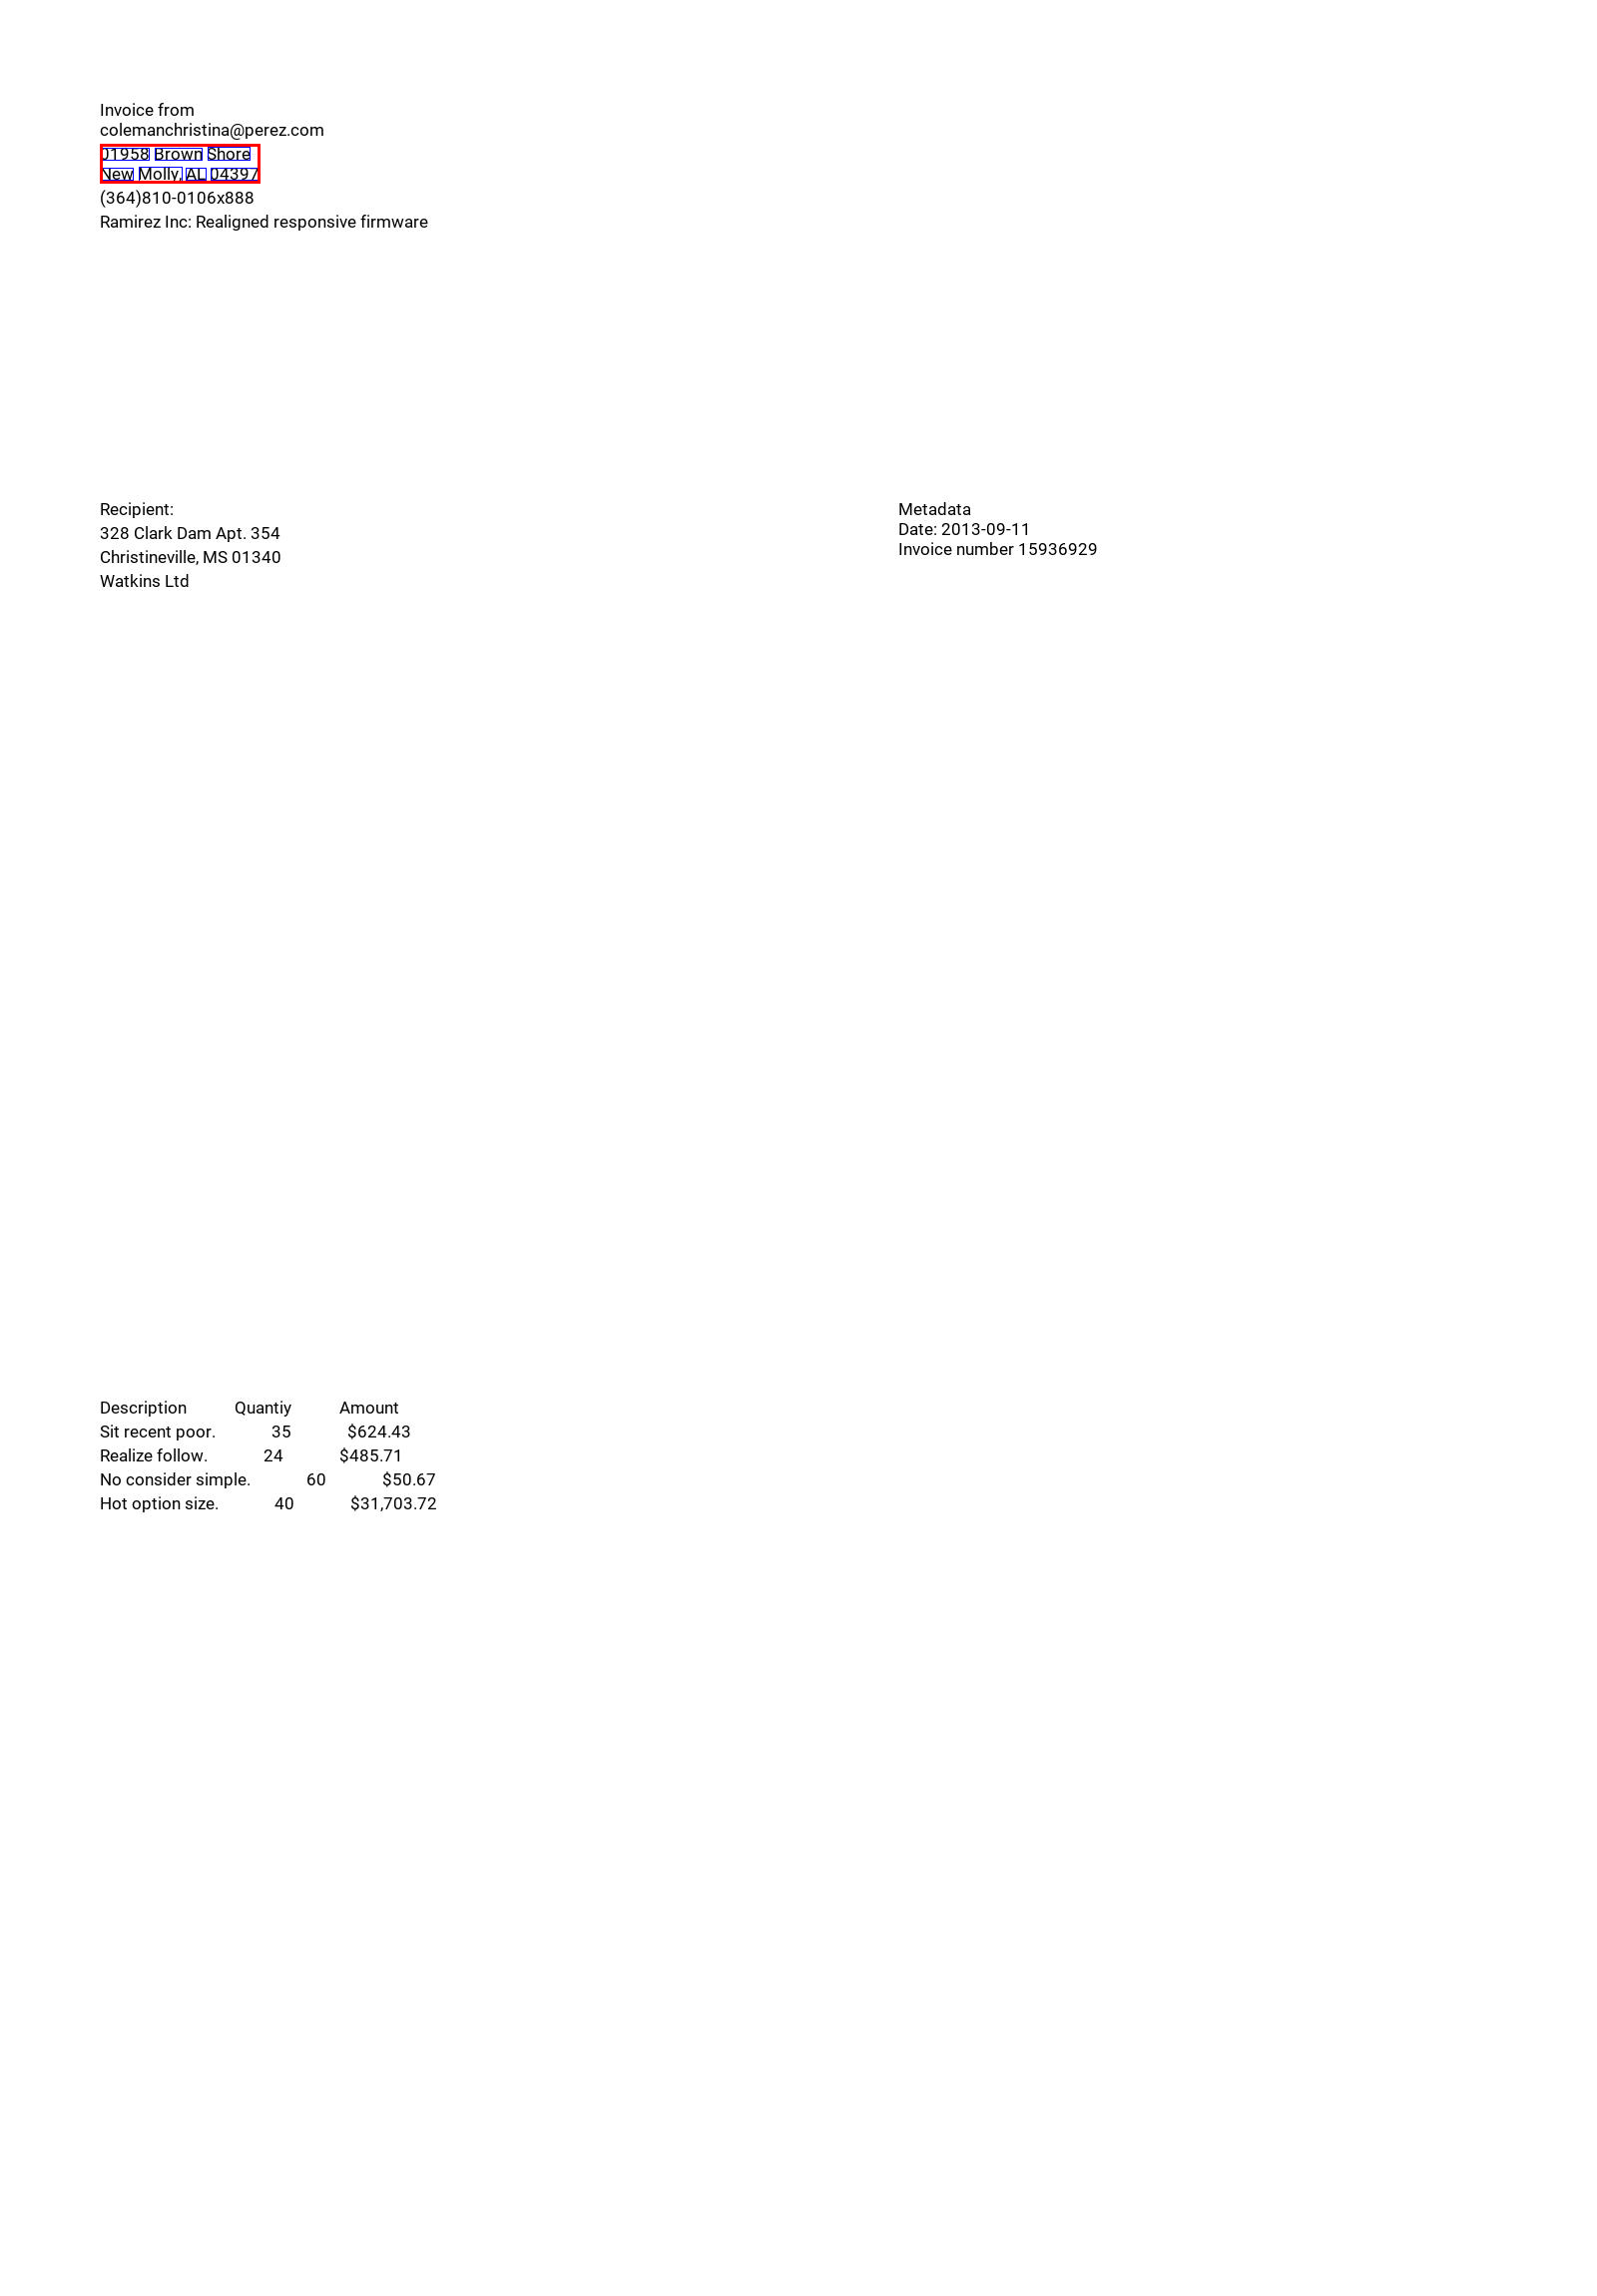

In [29]:
from utils import display_prediction

key = keys[0].item()
peaks = peak_indices[0].tolist()
doc = documents[str(key)]
display_prediction(doc, peaks)

# Inspecting the results

In [30]:
from utils import get_threshold_data, get_metrics

### Validation

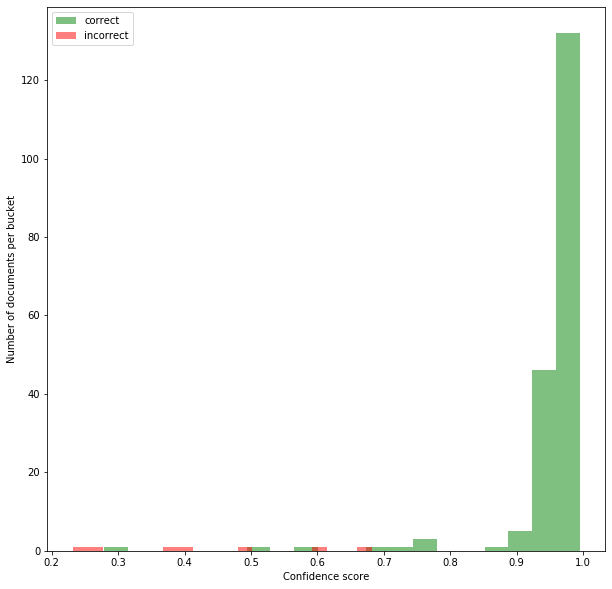

In [39]:
val_threshold_data = get_threshold_data(model, optimizer, val_loader)

correct = val_threshold_data.loc[val_threshold_data.is_correct].confidence.values
incorrect = val_threshold_data.loc[~val_threshold_data.is_correct].confidence.values

plt.figure(figsize=(10, 10))
plt.hist(correct, bins=20, alpha=0.5, color='green', label='correct')
plt.hist(incorrect, bins=20, alpha=0.5, color='red', label='incorrect')
plt.xlabel('Confidence score')
plt.ylabel('Number of documents per bucket')
plt.legend()
plt.show()

### Test

In [32]:
test_threshold_data = get_threshold_data(model, optimizer, test_loader)
get_metrics(test_threshold_data)

{'accuracy': 0.915, 'PR-AUC': 0.9992830292995503}

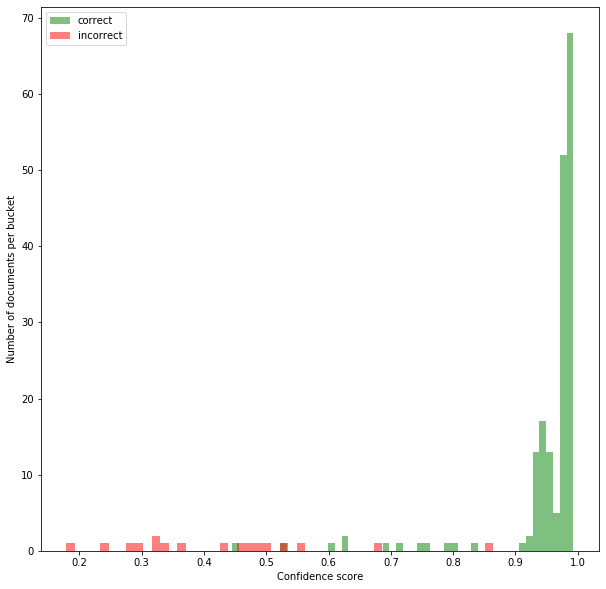

In [33]:
correct = test_threshold_data.loc[test_threshold_data.is_correct].confidence.values
incorrect = test_threshold_data.loc[~test_threshold_data.is_correct].confidence.values

plt.figure(figsize=(10, 10))
plt.hist(correct, bins=50, alpha=0.5, color='green', label='correct')
plt.hist(incorrect, bins=50, alpha=0.5, color='red', label='incorrect')
plt.xlabel('Confidence score')
plt.ylabel('Number of documents per bucket')
plt.legend()
plt.show()

# Automation and accuracy

### Compute threshold on validation

In [34]:
from utils import find_threshold

target_accuracy = 0.99
accuracies, automations, threshold_99acc = find_threshold(target_accuracy, val_threshold_data)

thresholds = np.linspace(val_threshold_data.confidence.min(), 1, 100)

In [35]:
threshold_99acc

0.5962520320006091

In [36]:
val_above_threshold = val_threshold_data.loc[val_threshold_data.confidence > threshold_99acc]
val_accuracy = val_above_threshold.is_correct.mean()
val_automation = len(val_above_threshold)/len(val_threshold_data)
val_accuracy, val_automation

(0.9947368421052631, 0.9547738693467337)

### Plot automation and accuracy

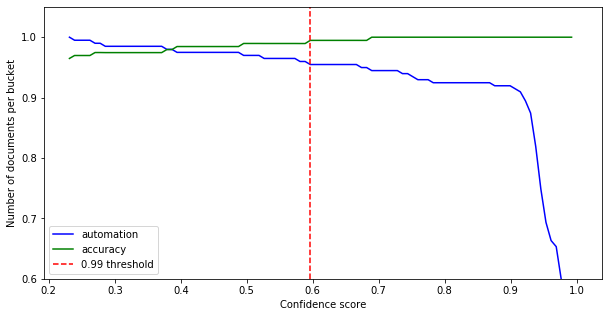

In [37]:
plt.figure(figsize=(10, 5))
plt.plot(thresholds, automations, color='blue', label='automation')
plt.plot(thresholds, accuracies, color='green', label='accuracy')
plt.axvline(x=threshold_99acc, color='red', linestyle='--', label='0.99 threshold')
plt.xlabel('Confidence score')
plt.ylabel('Number of documents per bucket')
plt.ylim(ymin=0.6)
plt.legend()
plt.show()

### Get tet automation and test accuracy at the threshold

In [38]:
test_above_threshold = test_threshold_data.loc[test_threshold_data.confidence > threshold_99acc]
test_accuracy = test_above_threshold.is_correct.mean()
test_automation = len(test_above_threshold)/len(test_threshold_data)
test_accuracy, test_automation

(0.9890710382513661, 0.915)